In [259]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
matplotlib.rcParams["xtick.labelsize"] = 20
matplotlib.rcParams["ytick.labelsize"] = 20
matplotlib.rcParams["image.cmap"] = "inferno"
matplotlib.rcParams["axes.titlesize"] = 25
matplotlib.rcParams["axes.labelsize"] = 25
from matplotlib import pyplot as plt

import pulse
import modulated_tls
import single_photon_emission
import two_photon_emission

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [260]:
class GaussianPulse(pulse.Pulse):
    def __init__(self, pulse_amp, t_mean, t_stddev):
        self._t_mean = t_mean
        self._t_stddev = t_stddev
        self._pulse_amp = pulse_amp

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        return self._pulse_amp * np.exp(
            -(t - self._t_mean)**2 / self._t_stddev**2)
    
    
class RectangularPulse(pulse.Pulse):
    def __init__(self, pulse_amp, pulse_len):
        self._pulse_amp = pulse_amp
        self._pulse_len = pulse_len

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        if t < self._pulse_len:
            return self._pulse_amp
        else:
            return 0
        
def compute_fourier_transform(phi, times, freqs):
    df = freqs[1] - freqs[0]
    fft_matrix = np.exp(
        -1.0j * freqs[:, np.newaxis] @ times[np.newaxis, :])/ np.sqrt(2 * np.pi) * df
    return fft_matrix @ phi
    

In [376]:
# Reproducing transmission spectrum.
gamma = 1 #98 * 1e-3
inp_freqs = np.linspace(-10, 10, 1000)
freq_2f = 1.500
amps = [2.910, 2.250]*0
phases = [0, 0]
harmonics = [1, 3]

delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)
tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta_2f)

pulse_width = 0.2 / gamma
pulse_area = np.pi*6

#pulse_amp = 0.5* pulse_area / (np.sqrt(np.pi) * pulse_width)
#laser_pulse = GaussianPulse(pulse_amp, pulse_width, 3*pulse_width)

pulse_amp = pulse_area / (2 * pulse_width)
laser_pulse = RectangularPulse(pulse_amp, pulse_width)

times = np.linspace(0, 3 / gamma, 2000)
output_2f = two_photon_emission.two_photon_emission(
        tls_obj_2f, times, laser_pulse, 1)

output_2f_freq = compute_fourier_transform(output_2f, times, inp_freqs)

0.5008754377188592
29447.241297726032


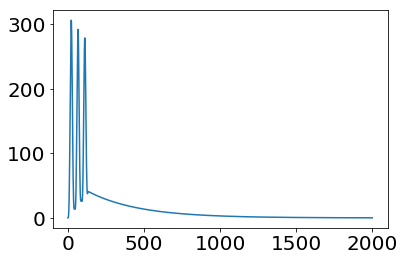

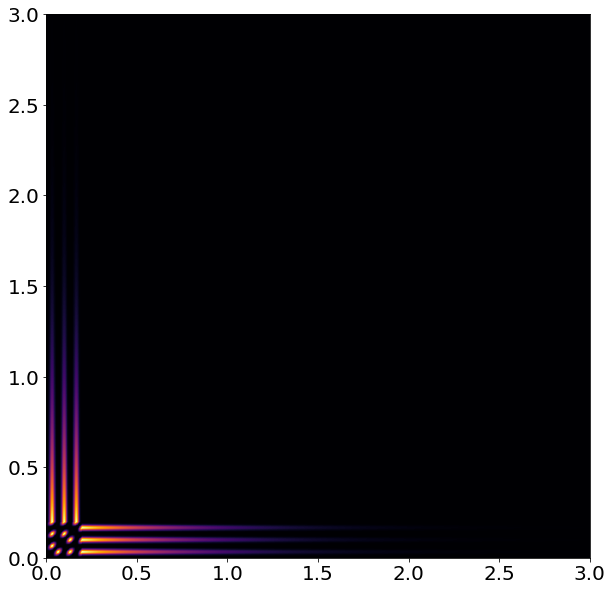

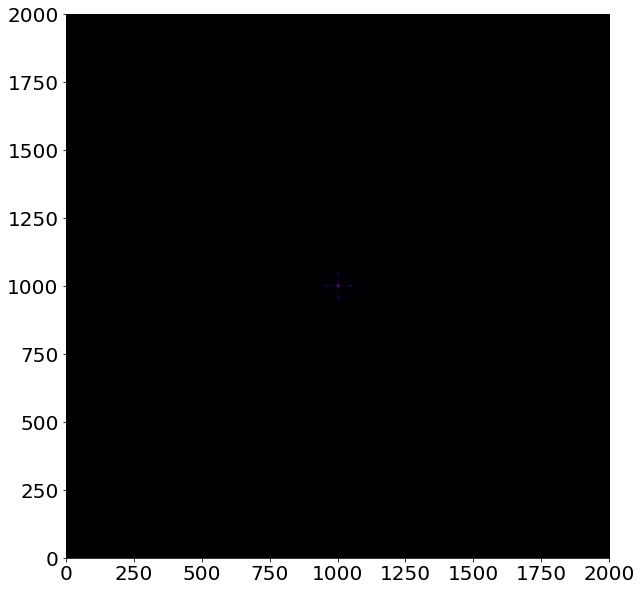

In [377]:
# plt.figure(figsize=(17, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(np.abs(output_2f_freq)**2, origin="lower", aspect=3.5,
#            extent=[times[0], times[-1], inp_freqs[0], inp_freqs[-1]])
# plt.xlabel("Time (ns)")
# plt.ylabel("Frequency (GHz)")
# plt.title(r"$|\phi(\omega, T)|^2$")
# plt.subplot(1, 2, 2)
# plt.plot(inp_freqs, np.abs(output_2f_freq[:, -1])**2)
# plt.xlabel("Frequency (GHz)")
# plt.title(r"$|\phi(\omega, T \to\infty)|^2$ (GHz$^{-1}$)")
# plt.show()

pulseVals = []
for t in times:
    pulseVals.append(laser_pulse(t))
print(np.trapz(pulseVals, times)/pulse_area)

print(np.sum(np.sum(np.abs(output_2f)**2)))
plt.plot(np.sum(np.abs(output_2f)**2, axis = -1))
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.abs(output_2f)**2, origin="lower", aspect=1,
           extent=[times[0]*gamma, times[-1]*gamma, times[0]*gamma, times[-1]*gamma])
plt.show()

plt.figure(figsize=(10,10))

plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(output_2f))), origin="lower")
plt.show()


In [211]:
# Reproducing transmission spectrum.
gamma = 98 * 1e-3
inp_freqs = np.linspace(-10, 10, 1000)
freq_4f = 1.200
amps = [2.360, 2.110, 2.220, 2.020, 2.250]
phases = [np.pi / 6, -np.pi / 6, np.pi / 2, -5 * np.pi / 6, 5 * np.pi / 6]
harmonics = [1, 2, 3, 4, 5]
delta_4f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_4f)
tls_obj_4f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_4f)

pulse_width = 0.05 / gamma
pulse_area = np.pi
pulse_amp = pulse_area / (np.sqrt(np.pi) * pulse_width)
laser_pulse = GaussianPulse(10, pulse_width, 3 * pulse_width)
times = np.linspace(0, 10 / gamma, 2000)
output_4f = single_photon_emission.single_photon_emission(
        tls_obj_4f, times, laser_pulse, 1)

output_4f_freq = compute_fourier_transform(output_4f, times, inp_freqs)

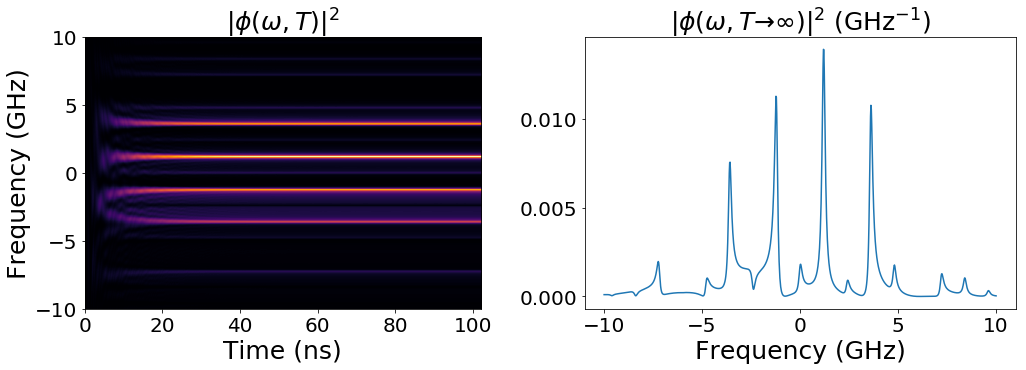

In [6]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(output_4f_freq)**2, origin="lower", aspect=3.5,
           extent=[times[0], times[-1], inp_freqs[0], inp_freqs[-1]])
plt.title(r"$|\phi(\omega, T)|^2$")
plt.xlabel("Time (ns)")
plt.ylabel("Frequency (GHz)")
plt.subplot(1, 2, 2)
plt.plot(inp_freqs, np.abs(output_4f_freq[:, -1])**2)
plt.xlabel("Frequency (GHz)")
plt.title(r"$|\phi(\omega, T \to\infty)|^2$ (GHz$^{-1}$)")
plt.show()